<a href="https://colab.research.google.com/github/CitricAmoeba/INT2-Group2/blob/main/CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
batch_size = 32

# Composition of several image transformations to perform on the training data
train_transform = transforms.Compose([
                                transforms.RandomCrop(32, 4),
                                transforms.RandomHorizontalFlip(),
                                #transforms.ColorJitter(0.2, 0.2),
                                #transforms.RandomAffine(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
                                ])

# Normalization mean and std calculated from: trainset.data.mean(axis=(0,1,2))/255 and trainset.data.std(axis=(0,1,2))/255


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 50000 images

# Testing data normalization
test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.494, 0.485, 0.450), (0.247, 0.243, 0.261))
                                    ])
# Normalization mean and std calculated from: testset.data.mean(axis=(0,1,2))/255 and testset.data.std(axis=(0,1,2))/255

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 10000 images

classes = trainset.classes # Categories of images

accuracy0 = [] # Cyclic
avg_loss0 = []
lrs = []
#lr_loss = []

accuracy1 = [] # 1e-2
avg_loss1 = []

accuracy2 = [] # 5e-3
avg_loss2 = []

accuracy3 = [] # 1e-3
avg_loss3 = []

accuracy4 = [] # 5e-4
avg_loss4 = []


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
!nvidia-smi -L
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-77be9472-90a8-766b-e62f-aab57f502bdd)
Using cuda device


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 256, 5)
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = x.view(-1, 256 * 5 * 5)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x


net = Net()
net.to(device)

print(net)

Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 256, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)
step_size = len(trainloader.dataset) // batch_size * 15
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=7.5e-3, step_size_up=step_size, mode='triangular2')

# Use to determine base and max lr
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=5e-2, step_size_up=step_size)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step() 
        lr = optimizer.param_groups[0]['lr']
        # lr_loss.append([lr, loss])
        lrs.append(lr)
        momentum = optimizer.param_groups[0]['momentum']
        
        if batch % (len(dataloader) // 5) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] lr: {lr:.8f} momentum: {momentum:.5f}")

In [ ]:
def test(dataloader, model, accuracy, avg_loss):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy.append(100*correct)
    avg_loss.append(test_loss)

In [ ]:
epochs = 120

print("Cyclic LR")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net, accuracy0, avg_loss0)

print("Done!")

Cyclic LR
Epoch 1
-------------------------------
loss: 0.449304  [    0/50000] lr: 0.00003178 momentum: 0.89971
loss: 0.403207  [ 9984/50000] lr: 0.00004425 momentum: 0.89954
loss: 0.440858  [19968/50000] lr: 0.00005671 momentum: 0.89938
loss: 0.130807  [29952/50000] lr: 0.00006918 momentum: 0.89921
loss: 0.349489  [39936/50000] lr: 0.00008165 momentum: 0.89904
loss: 0.447922  [49920/50000] lr: 0.00009411 momentum: 0.89888
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.012320 

Epoch 2
-------------------------------
loss: 0.504058  [    0/50000] lr: 0.00009423 momentum: 0.89888
loss: 0.329515  [ 9984/50000] lr: 0.00010670 momentum: 0.89871
loss: 0.109800  [19968/50000] lr: 0.00011917 momentum: 0.89854
loss: 0.500412  [29952/50000] lr: 0.00013164 momentum: 0.89838
loss: 0.268197  [39936/50000] lr: 0.00014410 momentum: 0.89821
loss: 0.239793  [49920/50000] lr: 0.00015657 momentum: 0.89804
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.012284 

Epoch 3
-------------------------------
loss: 0.34

In [ ]:
# Use for cyclic lr parameters
# plt.xlabel('learning rate')
# plt.ylabel('test accuracy')
# plt.plot([x for (i,x) in enumerate(lrs) if i%1563 == 0][:12], accuracy0[:12])
# plt.savefig('learning rate vs accuracy for cyclic lr.png')
# plt.show()

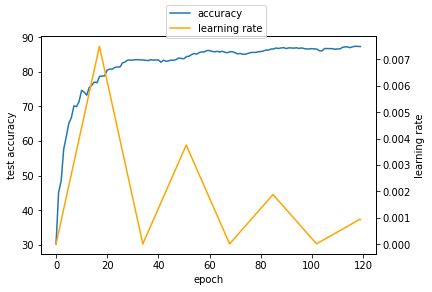

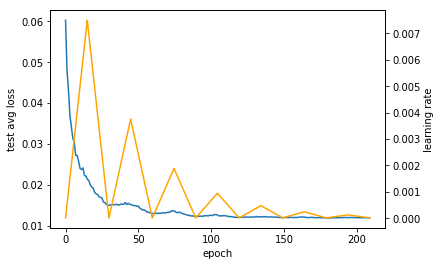

In [ ]:
# Epochs against accuracy and learning rate
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('epoch')
ax.set_ylabel('test accuracy')
ax.plot(list(range(len(accuracy0[:120]))), accuracy0[:120], label="accuracy")
ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.set_ylabel('learning rate')
ax2.plot(list(range(len(lrs[:164342]))), lrs[:164342], color='orange', label='learning rate')
fig.legend(loc='upper center')
fig.savefig('epochs vs accuracy.pdf', bbox_inches='tight')

# Epochs against loss and learning rate
fig2 = plt.figure()
ax = fig2.add_subplot()
ax.set_xlabel('epoch')
ax.set_ylabel('test avg loss')
ax.plot(list(range(len(avg_loss0))), avg_loss0)
ax2 = ax.twiny().twinx()
ax2.set_xticks([])
ax2.set_ylabel('learning rate')
ax2.plot(list(range(len(lrs))), lrs, color='orange')
fig.savefig('epochs vs loss.png')

plt.show()

In [ ]:
# Plot learning rate against loss for cyclic lr parameter determination
# plt.xlabel('learning rate')
# plt.ylabel('loss')
# plt.ylim(0, 4)

#plt.plot(np.array(lr_loss)[:, 0], np.array(lr_loss)[:, 1])

In [ ]:
# Calculate class breakdown of accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = torch.zeros(len(testset.classes), len(testset.classes))
with torch.no_grad():
    net.eval()
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for t, p in zip(y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        for i in range(16):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print(f'Accuracy of {classes[i]:10s} : {(100 * class_correct[i] / class_total[i]):.0f}%')

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots()

ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.set_size_inches(10, 10)

plt.xticks(range(len(testset.classes)), testset.classes)
plt.yticks(range(len(testset.classes)), testset.classes)

for i in range(10):
    for j in range(10):
        c = confusion_matrix[j, i]
        ax.text(i, j, str(int(c)), va='center', ha='center', c='w' if c > 500 else 'k')
fig.savefig('confusion_matrix.png')
plt.show()

In [ ]:
!pip install hiddenlayer
import hiddenlayer as hl

net.train()
hl_graph = hl.build_graph(net, torch.zeros([1, 3, 32, 32]).to(device))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph